In [1]:
from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.image as img

### Read the FITS file

In [2]:
data = fits.open("../dataset/example.fits", memmap = True)
image = data[0].data

### Check the original image.

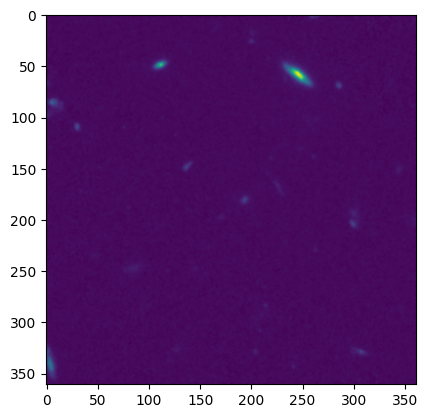

In [3]:
plt.imshow(image)
plt.show()

### Plot the histogram of the pixels in the image

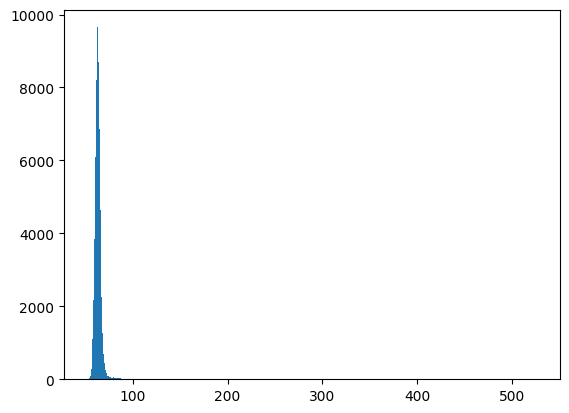

In [4]:
plt.hist(image.flatten(), bins = 1000)
plt.show()

To see more detail of the distribution, we can constraint the range of the value of the pixels (x-axis).

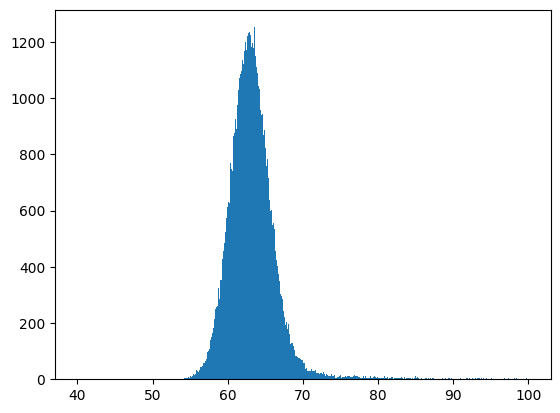

In [5]:
plt.hist(image.flatten(), bins = 1000, range = (40, 100))
plt.show()

You can notice that it looks like a Gaussain distribution.

Furthermore, for each pixel, since each photon detected is unrelated to each other, you can assume it is Poisson distribution. However, it is essential to calculate the variance and the mean to test the assumption.

In [6]:
mean = np.mean(image)
var = np.std(image, ddof = 1) ** 2
print(f"Mean value: {mean} / Variance: {var}" )

Mean value: 64.14060974121094 / Variance: 152.11484360335453


We can see they are not identical, so does that mean the assumption is wrong?
Maybe, but there is a issue that we should pay attention to, which is the value of the each pixel.
That is to say, it is not necessary that the value of each pixel equals to the number of received photon.
Typically, there is a linear relation between the value and the number of photon.
And we can find the coeffecient of the relation via following program.
### Calculate the coeffecient

In [7]:
def solve(small, big, data, thres):
    half = (small + big) / 2
    iter = True
    if abs(np.mean(image / half) - np.std(image / half, ddof = 1) ** 2) ** 2 < thres:
        iter = False
    if iter:
        if (np.mean(image / half) - np.std(image / half, ddof = 1) ** 2) * (np.mean(image / big) - np.std(image / big, ddof = 1) ** 2) < 0:
            half = solve(small = half, big = big, data = data, thres = thres)
        elif (np.mean(image / half) - np.std(image / half, ddof = 1) ** 2) * (np.mean(image / small) - np.std(image / small, ddof = 1) ** 2) < 0:
            half = solve(small = small, big = half, data = data, thres = thres)
        else:
            pass
    return half

In [8]:
coeff = solve(small = 1, big = 64, data = image, thres = 0.001)
print(coeff)

2.368896484375


### Build up a function to remove the pixels that belong to possible celestial objects.

In [9]:
def remove_object(image, sigma = 3):
    bg = image.copy()
    mask = bg > np.mean(bg) + sigma * np.std(bg, ddof = 1)
    bg[mask] = np.NAN
    plt.imshow(bg)
    plt.show()
    remove = np.count_nonzero(np.isnan(bg))
    return image, np.nanmean(bg), np.nanstd(bg, ddof = 1) / (bg.shape[0] * bg.shape[1] - remove) ** (1 / 2)

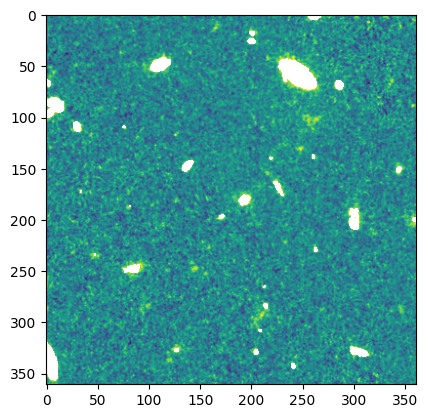

background mean: 63.12681198120117 / uncertainty: 0.0077535665898625155


In [10]:
bg, bg_mean, bg_err = remove_object(image, sigma = 1)
print(f"background mean: {bg_mean} / uncertainty: {bg_err}")